In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""

def add_noise(img,seed,noise_type="gaussian"):
  np.random.seed(seed) 
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-3.9,3.9,img.shape)
    noise = torch.from_numpy(noise)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(img.shape)
    noise = torch.from_numpy(noise)
    img=img+img*noise
    return img

In [3]:
import os
import matplotlib
import pylab
import librosa
import numpy as np
!pip install soundfile
!pip install torchaudio
import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

from google.colab import drive
drive.mount('/content/gdrive')

def createSpectrogram(filename, n_mels=128, n_fft=2048, hop_length=512):
  #librosa supports only monophonic audio! apprently our data is stereo (2 channels, 44100 fs)
  sig, sr = sf.read(filename)
  sig = sig.mean(axis=1)
  S = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
  return S, sr

def plotData(S_DB, sr=44100, hop_length=512):
  #S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');


def saveDataAsImage(S, save_path):
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()


#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio
import torchaudio

def loadRec(wavPath):
  sound, sample_rate = torchaudio.load(wavPath)
  print("sample_rate", sample_rate)
  return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
  path = F"{path}/{model_name}.pt"
  torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    model.load_state_dict(torch.load(path))
    return model

     |████████████████████████████████| 6.7MB 6.6MB/s 
Mounted at /content/gdrive


In [4]:
from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
from torch.utils import data
from torchvision import datasets, models, transforms

class Dataset(data.Dataset):
    def __init__(self, fileNames, labels, dataPath, numClasses):
        'Initialization'

        self.labels = labels
        self.file_names = fileNames
        self.data_path = dataPath
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        label = self.labels[index]
        file = os.path.join(self.data_path, str(label), str(file_name))
        #S, sr = createSpectrogram(file, 128, 22050, 10390)
        S, sr = createSpectrogram(file, 512, 5510, 2590)
        if(S.shape[1] < 512):
          #print("S.shape before ", S.shape)
          S = np.pad(S, ((0,0),(0,1)), 'constant')
          #print("S.shape after ", S.shape)
        Mel = librosa.power_to_db(S, ref=np.max)
        label_out = np.zeros(self.num_classes)
        label_out[label-2] = 1
        label_out = torch.from_numpy(label_out).double()
        Im = torch.from_numpy(Mel).float()
        Im_wn = add_noise(Im,index) 
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])

        return Im,Im_wn,label_out,timestamp

In [5]:
import os
import pandas as pd
import random
random.seed(1)

num_classes = 10

wav_path = "/content/gdrive/My Drive/Project/Recs"
#Load train data
labels = pd.read_csv(os.path.join(wav_path, "labels.csv"))
n_samples = len(labels)
print(n_samples)
train_len = int(n_samples * 0.85)
valid_len = int((n_samples - train_len) * 0.01)
test_len = n_samples - train_len - valid_len
total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)
test_list = list(set(total_list)^set(valid_list))

train_data = labels.iloc[train_list]
valid_data = labels.iloc[valid_list]
test_data = labels.iloc[test_list]

training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), wav_path, num_classes)
batch_size = 8
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)
#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), wav_path, num_classes)
batch_size = 2
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)
#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), wav_path, num_classes)
batch_size = 2
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")

6108
Training set contains 5191 samples
Validation set contains 9 samples
Test set contains 908 samples


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 2), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 3, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.MaxPool2d(2,stride=(2,2),padding=1)
        self.pool2 = nn.MaxPool2d(2,stride=(2,2),padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # compressed representation
                
        return x

class ConvAutodecoder(nn.Module):
    def __init__(self):
        super(ConvAutodecoder, self).__init__()
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(3, 16, 3, padding=1, stride=(2,2))
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 4, padding=0, stride=(2,2))

    def forward(self, x):
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
                
        return x

import torch.nn as nn
import torch.nn.functional as F

# initialize the NN
encode_model = ConvAutoencoder()
encode_model.cuda()
decode_model = ConvAutodecoder()
decode_model.cuda()
print(encode_model)
print(decode_model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)
ConvAutodecoder(
  (t_conv1): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
)


Calculate Test loss function

In [7]:
@torch.no_grad()
def calculateTestLoss(encode_model, decode_model):
  test_loss = 0.
  for dataBatch,_,_,_ in test_generator:
      images = dataBatch.unsqueeze(1).float().cuda()
      encoded_outputs = encode_model(images)
      outputs = decode_model(encoded_outputs)
      loss = criterion(outputs*(-1), images)
      test_loss += loss.item()*images.size(0)

  return test_loss/len(test_generator)

In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
encode_optimizer = torch.optim.Adam(encode_model.parameters(), lr=0.001)
decode_optimizer = torch.optim.Adam(decode_model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20

idx = 0

encode_model_name = "convAutoencoder3"
decode_model_name = "convAutodecoder3"

encode_model = loadModel(encode_model, encode_model_name + "_3", "/content/gdrive/My Drive/Project/Encoder/")
decode_model = loadModel(decode_model, decode_model_name + "_3", "/content/gdrive/My Drive/Project/Encoder/")

for epoch in range(4, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for dataBatch,dataBatchWithNoise, target,_ in training_generator:
        #print("dataBatch.shape", dataBatch.shape)
        
        idx+=1

        images = dataBatch.unsqueeze(1).float()
        images_with_noise = dataBatchWithNoise.unsqueeze(1).float()
        # Add noise
        #images_with_noise = add_noise(images) 
        # clear the gradients of all optimized variables
        encode_optimizer.zero_grad()
        decode_optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        images = images.cuda()
        images_with_noise = images_with_noise.float().cuda()
        encoded_outputs = encode_model(images_with_noise)
        outputs = decode_model(encoded_outputs)
        # calculate the loss
        loss = criterion(outputs*(-1), images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        encode_optimizer.step()
        decode_optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(training_generator)
    test_loss = calculateTestLoss(encode_model, decode_model)
    print('Epoch: {} \tTrain Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch, train_loss, test_loss))
    saveModel(encode_model, encode_model_name + "_" + str(epoch), "/content/gdrive/My Drive/Project/Encoder/")
    saveModel(decode_model, decode_model_name + "_" + str(epoch), "/content/gdrive/My Drive/Project/Encoder/")
    
saveModel(encode_model, encode_model_name, "/content/gdrive/My Drive/Project/Encoder/")
saveModel(decode_model, decode_model_name, "/content/gdrive/My Drive/Project/Encoder")

Epoch: 4 	Train Loss: 97.622618	 Test Loss: 46.188751
Epoch: 5 	Train Loss: 93.558577	 Test Loss: 44.194286
Epoch: 6 	Train Loss: 91.955222	 Test Loss: 42.736982
Epoch: 7 	Train Loss: 90.984605	 Test Loss: 47.096558
Epoch: 8 	Train Loss: 90.250106	 Test Loss: 47.788897
Epoch: 9 	Train Loss: 89.699466	 Test Loss: 46.998635
Epoch: 10 	Train Loss: 89.354962	 Test Loss: 52.459839
Epoch: 11 	Train Loss: 88.804843	 Test Loss: 48.776011
Epoch: 12 	Train Loss: 88.398194	 Test Loss: 49.545979
Epoch: 13 	Train Loss: 88.024644	 Test Loss: 48.535921
Epoch: 14 	Train Loss: 87.718653	 Test Loss: 49.859086
Epoch: 15 	Train Loss: 87.497152	 Test Loss: 48.117525
Epoch: 16 	Train Loss: 87.225572	 Test Loss: 54.814706
Epoch: 17 	Train Loss: 87.001496	 Test Loss: 52.441166
Epoch: 18 	Train Loss: 86.672801	 Test Loss: 52.433186
Epoch: 19 	Train Loss: 86.557785	 Test Loss: 52.612311
Epoch: 20 	Train Loss: 86.347674	 Test Loss: 54.323193


torch.Size([3, 128, 128])


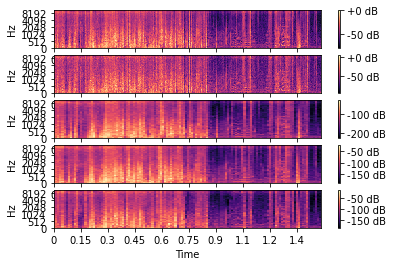

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

with torch.no_grad():
    for dataBatch, _, _ in test_generator:
        images = dataBatch.float()
        img = images[0,:,:]
        plt.subplot(5, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
        plotData(img.numpy(),hop_length=512)
        img_noise = add_noise(img)
        plt.subplot(5, 1, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
        plotData(img_noise.numpy(),hop_length=512)
        img_noise = img_noise.unsqueeze(0).unsqueeze(1).float()
        output = encode_model(img_noise.cuda())
        output = output.cpu().squeeze(1).squeeze(0)
        print(output.shape)
        output *= -1
        plt.subplot(5, 1, 3)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
        output = output.numpy()
        plotData(output[0,:,:],hop_length=512)
        plt.subplot(5, 1, 4)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
        plotData(output[1,:,:],hop_length=512)
        plt.subplot(5, 1, 5)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
        plotData(output[2,:,:],hop_length=512)
        break

In [ ]:
S, sr = createSpectrogram("/content/gdrive/My Drive/Project/Recs/2/20200324_183400.wav", 22050, 10390)
plotData(S, sr, 512)

In [ ]:
with torch.no_grad():
    for dataBatch, _, _ in test_generator:
        images = dataBatch.unsqueeze(1).float()
        #img_noise = add_noise(images)
        #img_noise = img_noise.unsqueeze(0).unsqueeze(1).float()
        outputs = encode_model(images.cuda())
        encoded_outputs = outputs.cpu().squeeze(1).squeeze(0)
        print(encoded_outputs.shape)
        outputs = decode_model(outputs)
        outputs = outputs.cpu().squeeze(1).squeeze(0)
        print(outputs.shape)
        break

torch.Size([2, 2, 128, 128])
torch.Size([2, 512, 512])


In [ ]:
plt.figure(figsize=(8, 10))

filename = "Dataset_Encoded/2/20200324_232700.pt"

Im = torch.load(filename).squeeze(0).cpu()
plt.subplot(6, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[0,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 1')
plt.tight_layout()

plt.subplot(6, 1, 2)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[1,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 2')
plt.tight_layout()

plt.subplot(6, 1, 3)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[2,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 3')
plt.tight_layout()

Im = torch.load("Dataset_Mono/2/20200324_232700.pt")
plt.subplot(6, 1, 4)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im.detach().numpy(),hop_length=512)
plt.title('Mono')
plt.tight_layout()

#rp = np.max(Im.detach().numpy())
Im = torch.load("Dataset_HPSS/2/20200324_232701.pt")
Im = Im.detach().numpy()
#rp = np.max(np.abs(Im[0,:,:]))
plt.subplot(6, 1, 5)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[0,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Harmonic')
plt.tight_layout()

plt.subplot(6, 1, 6)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[1,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 10))

filename = ""

Im = torch.load("Dataset_Encoded/2/20200324_232700.pt").squeeze(0).cpu()
plt.subplot(6, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[0,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 1')
plt.tight_layout()

plt.subplot(6, 1, 2)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[1,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 2')
plt.tight_layout()

plt.subplot(6, 1, 3)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[2,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 3')
plt.tight_layout()

Im = torch.load("Dataset_Mono/2/20200324_232700.pt")
plt.subplot(6, 1, 4)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im.detach().numpy(),hop_length=512)
plt.title('Mono')
plt.tight_layout()

#rp = np.max(Im.detach().numpy())
Im = torch.load("Dataset_HPSS/2/20200324_232700.pt")
Im = Im.detach().numpy()
#rp = np.max(np.abs(Im[0,:,:]))
plt.subplot(6, 1, 5)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[0,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Harmonic')
plt.tight_layout()

plt.subplot(6, 1, 6)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[1,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive')
plt.tight_layout()